<a href="https://colab.research.google.com/github/Chaitanya-14/Image_classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/Chaitanya-14/Image_classification.git


Cloning into 'Image_classification'...
remote: Enumerating objects: 5704, done.
remote: Total 5704 (delta 0), reused 0 (delta 0), pack-reused 5704 (from 3)
Receiving objects: 100% (5704/5704), 43.39 MiB | 7.98 MiB/s, done.
Resolving deltas: 100% (693/693), done.
Updating files: 100% (5731/5731), done.


In [5]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: buddhavaramchaitanya
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:08<00:00, 87.5MB/s]


In [6]:
import torch
from torch import nn  #neural layers and loss functions
from torch.optim import Adam   #optimiser
from torchvision.transforms import transforms   # for transforming the data
from torch.utils.data import Dataset, DataLoader   #dataloading
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder    #data encoding
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [7]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)


df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df.head()
df['labels'].unique()


array(['dog', 'wild', 'cat'], dtype=object)

In [9]:
df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [8]:
## splitting the dataset in to the three train test and val

train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)
print("Val shape: ", val.shape)


Train shape:  (11291, 2)
Test shape:  (2419, 2)
Val shape:  (2420, 2)


In [10]:
label_encoder = LabelEncoder()

label_encoder.fit(df["labels"])   # this will translate the cat,wild dog to numericals

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])    #it will transform the image having the same properties like size and others


In [11]:
## creating a custom dataset

class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform =  None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)   # first the strings are getting transformed to the integers in the inner brackets, # then the labels are getting converted to the tensors and sent to the device

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]  # take the img path
    label = self.labels[idx]    #take the labels
    image = Image.open(img_path).convert('RGB')    # open it using the pillow lib

    if self.transform:
      image = self.transform(image).to(device)    #using transform fn above we willl transform the image acc to our specifications

    return image, label  # and return the transformed image and label

## Creating the dataset for training

In [12]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)


In [13]:
train_dataset.__getitem__(2)

(tensor([[[0.5451, 0.5373, 0.5294,  ..., 0.4078, 0.4000, 0.3961],
          [0.5451, 0.5373, 0.5294,  ..., 0.3569, 0.3490, 0.3451],
          [0.5451, 0.5373, 0.5294,  ..., 0.3216, 0.3216, 0.3176],
          ...,
          [0.6275, 0.6235, 0.6275,  ..., 0.6510, 0.6745, 0.7176],
          [0.6196, 0.6235, 0.6314,  ..., 0.6078, 0.5804, 0.6039],
          [0.6196, 0.6039, 0.6196,  ..., 0.5137, 0.4549, 0.4431]],
 
         [[0.4510, 0.4549, 0.4588,  ..., 0.3647, 0.3569, 0.3529],
          [0.4510, 0.4549, 0.4588,  ..., 0.3176, 0.3137, 0.3059],
          [0.4510, 0.4549, 0.4588,  ..., 0.2941, 0.2902, 0.2863],
          ...,
          [0.5647, 0.5608, 0.5686,  ..., 0.5882, 0.6000, 0.6471],
          [0.5529, 0.5569, 0.5647,  ..., 0.5412, 0.5020, 0.5373],
          [0.5451, 0.5294, 0.5451,  ..., 0.4431, 0.3804, 0.3725]],
 
         [[0.3412, 0.3412, 0.3412,  ..., 0.3569, 0.3490, 0.3451],
          [0.3412, 0.3412, 0.3412,  ..., 0.3098, 0.3020, 0.2980],
          [0.3412, 0.3412, 0.3412,  ...,

In [14]:
label_encoder.inverse_transform([0])
label_encoder.inverse_transform([1])
label_encoder.inverse_transform([2])


array(['wild'], dtype=object)

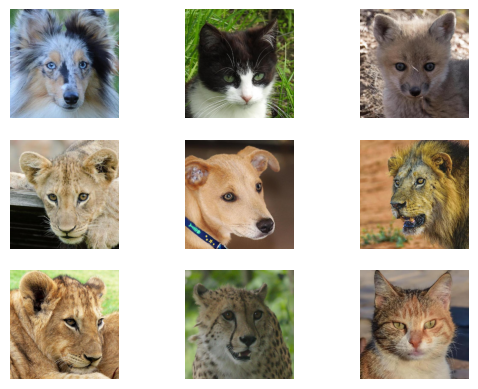

In [15]:
# visualising the images
#to have a look on some random images

n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range (n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [16]:
LR = 1e-4
BATCH_SIZE= 16
EPOCHS = 10



In [17]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE , shuffle = True )
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle =True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle =True)


## Building the model

In [18]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()  # we are just initialising the layers/ constructor
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding= 1 )   # 3 channels (RGB), outputs 32 channels (optional) ,kernel size is 3
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding= 1)
    self.conv3 = nn.Conv2d(in_channels= 64, out_channels=128, kernel_size = 3, padding= 1)

    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)   ## this is the sizze of the vector after our image passes through the flattened layer

    self.output = nn.Linear(128, len(df['labels'].unique())) # getting how many unique values are there cat dog wild

  def forward(self,x):   # how the data is flowing in the model
    x = self.conv1(x) # --> (32, 128 ,128) it does not change the size of image but increases the features
    x= self.pooling(x)   # --> (32,64,64) it does not change the amt of features but decreases the size of feature
    x = self.relu(x)  # dosent change anything, changes the value in the matrices

    x= self.conv2(x) # --> (64, 64,64)
    x = self.pooling(x) #--> (64,32,32)
    x = self.relu(x)

    x= self.conv3(x) # --> (128, 32,32)
    x = self.pooling(x) #--> (128,16,16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x





In [ ]:
# Conv NN

## more the output channels (feature maps) are coming they are better.
# max pooling layer = it keep sthe number same and reduces the size of the image (Dimention Reduction)
# next layer for extraction of more layers
# pooling layer dosent reduce the size but padding does,

# conv layer is to increase the feature maps but with the same size, pooling layer is to have to same amout and reduce their sizes.
#flattened layer - instead od having matrices - it keeps it in the big vector -
# big vector goes inside the multilayer perceptron and then dense layer and then output layer.


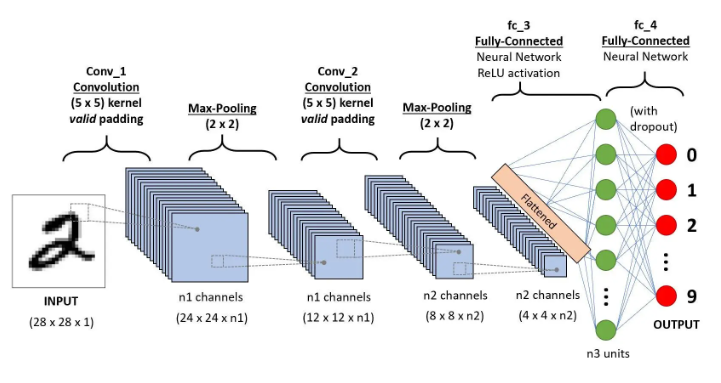

## Creating the Network

In [19]:
model = Net().to(device) # in pytorch we need to transfer everything to the device so that we have everything in the device

## seeing a model summary

In [20]:
from torchsummary import summary

summary(model, input_size =(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

Created the model and now we can start the training
## Starting the training


In [21]:
# before starting the training we must define the loss and optimiser

criterion = nn.CrossEntropyLoss()   #defining the cross entropy loss
optimiser = Adam(model.parameters(), lr = LR)   #adam optimiser parameters = weights and giving the learning rate



In [26]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

#to store the val of each epoch after training to check for the overfitting after training

for epoch in range(EPOCHS):    # training loop
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader: #loop through 16 inputs and labels 16*16
      optimiser.zero_grad()   # initialising optimiser with 0


      outputs = model(inputs)
      train_loss = criterion(outputs, labels)
      total_loss_train += train_loss.item()

      train_loss.backward()

      train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

      total_acc_train += train_acc
      optimiser.step()

    with torch.no_grad():   # without changing any weights (for validation)
      for inputs, labels in val_loader:
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        total_loss_val += val_loss.item()
        val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000,4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

    print(f''' Epoch {epoch +1}/{EPOCHS}, Train loss: {round(total_loss_train/1000*4)} Train Accuracy: {round((total_acc_train/train_dataset.__len__())*100,4)}
          Validation Loss {round(total_loss_val/1000*4)}  Validation Accuracy {round((total_acc_val/val_dataset.__len__())*100,4)}
    ''')



 Epoch 1/10, Train loss: 0 Train Accuracy: 97.2013
          Validation Loss 0  Validation Accuracy 95.9091
    
 Epoch 2/10, Train loss: 0 Train Accuracy: 97.8656
          Validation Loss 0  Validation Accuracy 94.3802
    
 Epoch 3/10, Train loss: 0 Train Accuracy: 98.5298
          Validation Loss 0  Validation Accuracy 96.1983
    
 Epoch 4/10, Train loss: 0 Train Accuracy: 99.194
          Validation Loss 0  Validation Accuracy 96.281
    
 Epoch 5/10, Train loss: 0 Train Accuracy: 99.1498
          Validation Loss 0  Validation Accuracy 96.5702
    
 Epoch 6/10, Train loss: 0 Train Accuracy: 99.3889
          Validation Loss 0  Validation Accuracy 96.5702
    
 Epoch 7/10, Train loss: 0 Train Accuracy: 99.5483
          Validation Loss 0  Validation Accuracy 96.157
    
 Epoch 8/10, Train loss: 0 Train Accuracy: 99.7077
          Validation Loss 0  Validation Accuracy 96.1157
    
 Epoch 9/10, Train loss: 0 Train Accuracy: 99.8052
          Validation Loss 0  Validation Accuracy

In [30]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions,labels)
    total_loss_test += test_loss.item()

print(f' Accuracy score is: {round((total_acc_test/test_dataset.__len__())*100,4)} and loss is {round(total_loss_test/1000,4)}')


 Accuracy score is: 96.4448 and loss is 0.0236


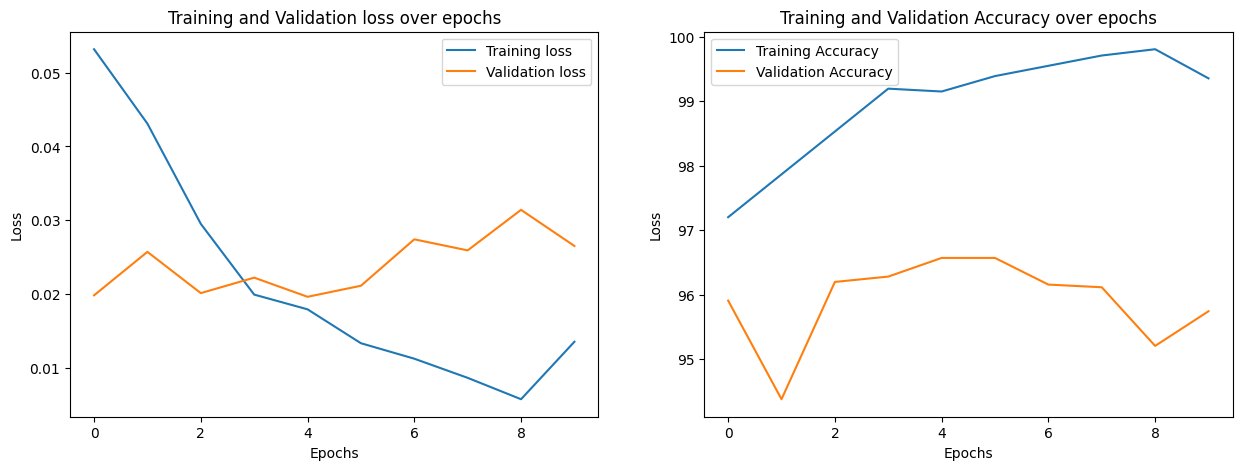

In [37]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
fig, axs = subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = "Training loss")
axs[0].plot(total_loss_val_plot, label= 'Validation loss')
axs[0].set_title('Training and Validation loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_val_plot, label= 'Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()